In [1]:
from plotting_utils import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import rankdata, ttest_ind
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
from itertools import combinations

In [2]:
datasets = [
    "Sulfonyl Fluoride 1", "Sulfonyl Fluoride 2", "Sulfonyl Fluoride 3", "Sulfonyl Fluoride 4", "Sulfonyl Fluoride 5", 
    "Amide", "Amine", "Sulfonamide", "Thiol", 
    "Whole amine", "Whole bromide"
]
all_models_ordered = ["Baseline", "RFR", "RFC", "KNN", "LRRF", "RPC", "IBM", "IBPL"]
rf_based_models_ordered = ["Baseline", "RFR", "RFC", "LRRF", "RPC"]

# Complete datasets with four reaction conditions

## Fingerprints

In [3]:
fp_analyzer = Analyzer("fp", all_models_ordered, 0)
fp_perf_df = fp_analyzer.avg_perf_df

fp_rr_table, fp_kt_table = get_rr_kt_tables(fp_perf_df, all_models_ordered)
p_rr, p_kt = run_friedman_tests(fp_rr_table, fp_kt_table, all_models_ordered)

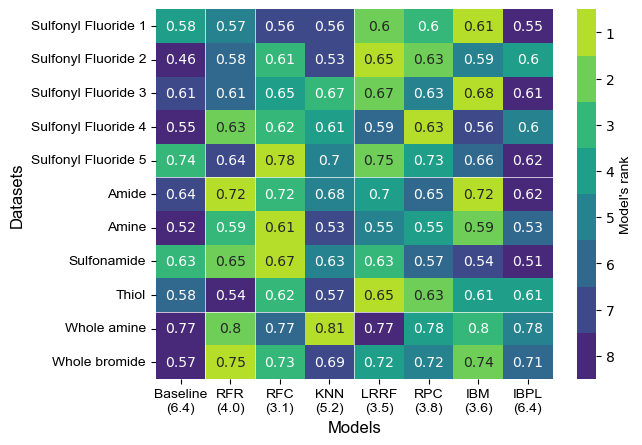

In [4]:
plot_rr_heatmap(fp_rr_table, all_models_ordered, datasets)

## DFT

In [5]:
desc_analyzer = Analyzer("desc", rf_based_models_ordered, 0)
desc_perf_df = desc_analyzer.avg_perf_df

In [6]:
# Then combine with the nearest-neighbor based models
combined_avg_perf_df = pd.concat([
    fp_perf_df[fp_perf_df["model"].isin(["KNN", "IBM", "IBPL"])], 
    desc_perf_df
])

combined_rr_table, combined_kt_table = get_rr_kt_tables(combined_avg_perf_df, all_models_ordered)
p_combined_rr, p_combined_kt = run_friedman_tests(combined_rr_table, combined_kt_table, all_models_ordered)

print(p_combined_rr, p_combined_kt)

0.00037354574164029895 0.0001601776192223515


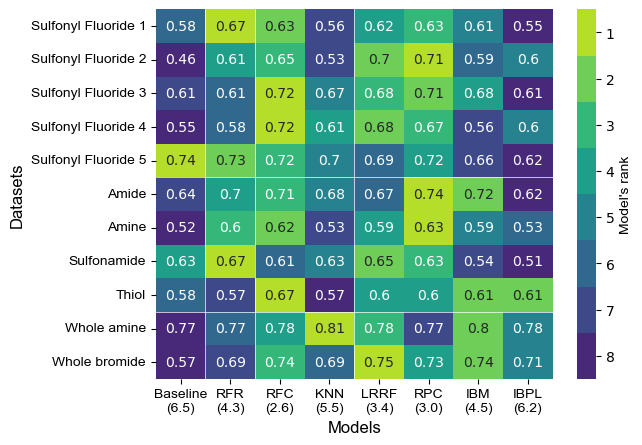

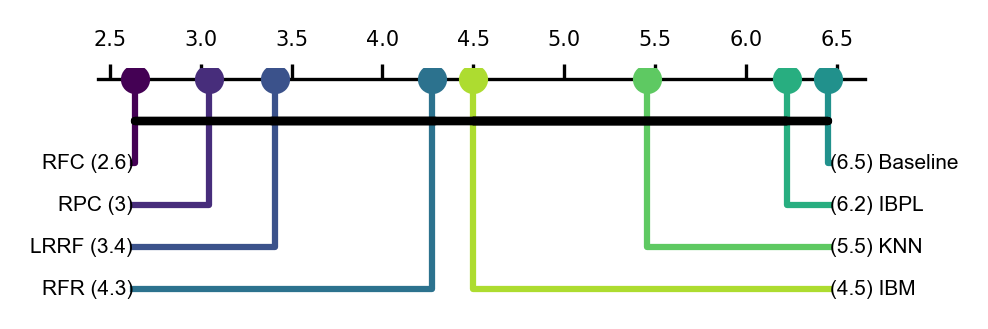

In [7]:
plot_rr_heatmap(combined_rr_table, all_models_ordered, datasets)
plot_bonferroni_dunn(combined_rr_table, all_models_ordered)

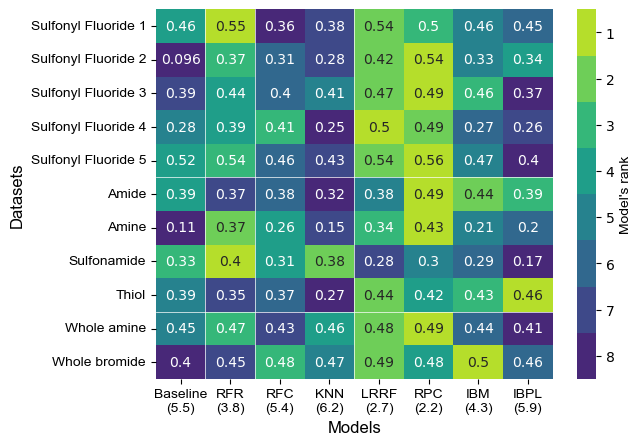

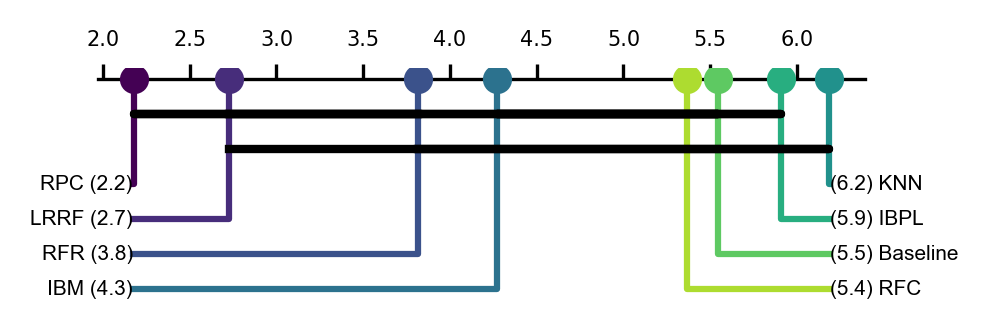

In [8]:
plot_rr_heatmap(combined_kt_table, all_models_ordered, datasets)
plot_bonferroni_dunn(combined_kt_table, all_models_ordered)

## Onehot

In [9]:
ohe_analyzer = Analyzer("onehot", rf_based_models_ordered, 0)
ohe_perf_df = ohe_analyzer.avg_perf_df
ohe_rr_table, ohe_kt_table = get_rr_kt_tables(ohe_perf_df, rf_based_models_ordered[1:])

# To compared with physical descriptors
desc_rr_table, desc_kt_table = get_rr_kt_tables(desc_perf_df, rf_based_models_ordered[1:])

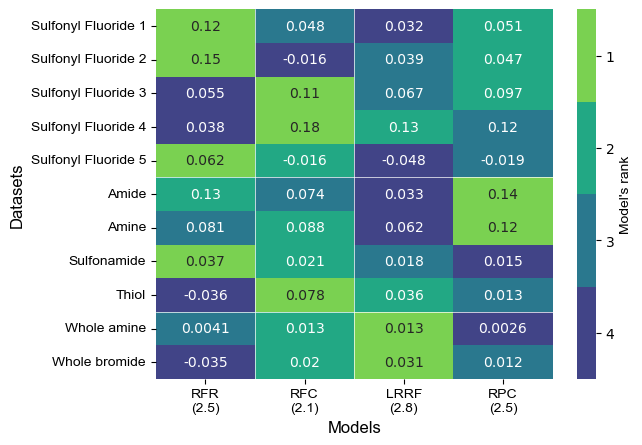

In [10]:
plot_rr_heatmap(desc_rr_table - ohe_rr_table, rf_based_models_ordered[1:], datasets)

## Random descriptors

In [11]:
rand_analyzer = Analyzer("random", rf_based_models_ordered[1:], 0)
rand_perf_df = rand_analyzer.avg_perf_df
rand_rr_table, rand_kt_table = get_rr_kt_tables(rand_perf_df, rf_based_models_ordered[1:])

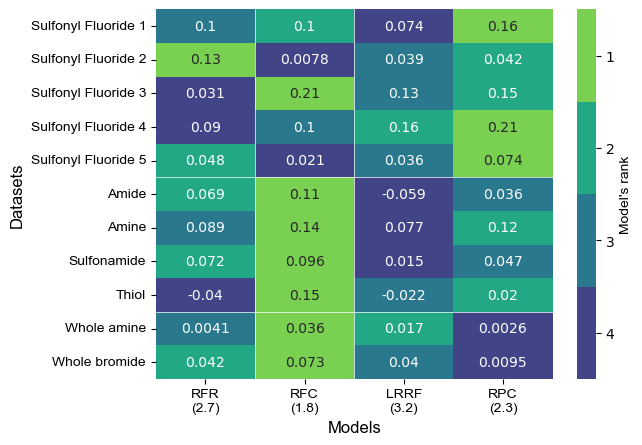

In [12]:
plot_rr_heatmap(desc_rr_table - rand_rr_table, rf_based_models_ordered[1:], datasets)

# Datasets randomly missing 25%

In [13]:
## For the NN_based models
m1_fp_analyzer = Analyzer("fp", all_models_ordered, 1)
m1_fp_perf_df = m1_fp_analyzer.avg_perf_df

# 
m1_desc_analyzer = Analyzer("desc", rf_based_models_ordered, 1)
m1_desc_perf_df = m1_desc_analyzer.avg_perf_df

# Then combine with the nearest-neighbor based models
m1_combined_avg_perf_df = pd.concat([
    m1_fp_perf_df[m1_fp_perf_df["model"].isin(["KNN", "IBM", "IBPL"])], 
    m1_desc_perf_df
])

m1_combined_rr_table, m1_combined_kt_table = get_rr_kt_tables(m1_combined_avg_perf_df, all_models_ordered)
m1_p_combined_rr, m1_p_combined_kt = run_friedman_tests(m1_combined_rr_table, m1_combined_kt_table, all_models_ordered)

print(m1_p_combined_rr, m1_p_combined_kt)

0.00015031475784421482 2.7850436958423737e-08


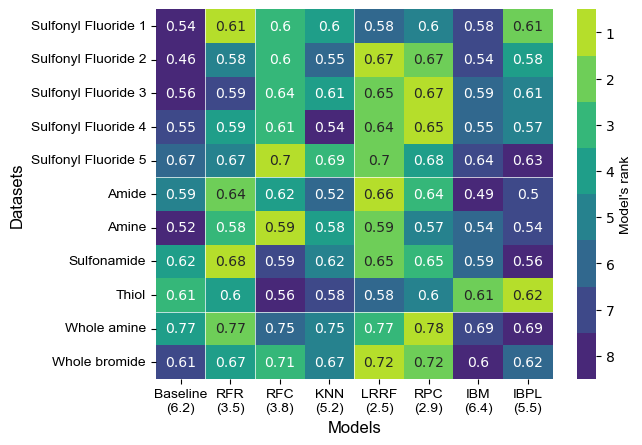

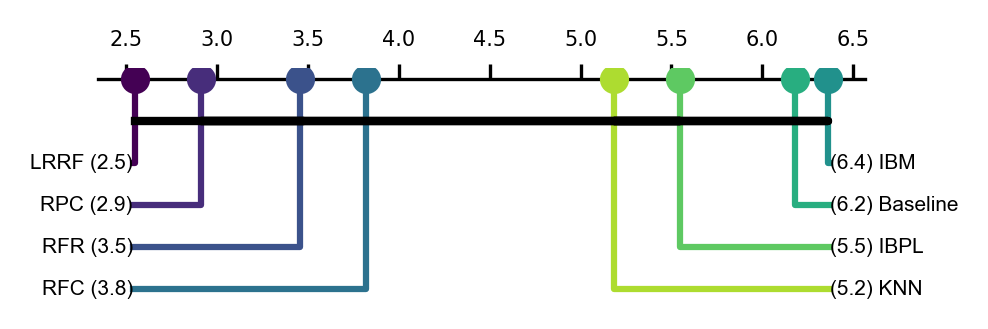

In [14]:
plot_rr_heatmap(m1_combined_rr_table, all_models_ordered, datasets)
plot_bonferroni_dunn(m1_combined_rr_table, all_models_ordered)

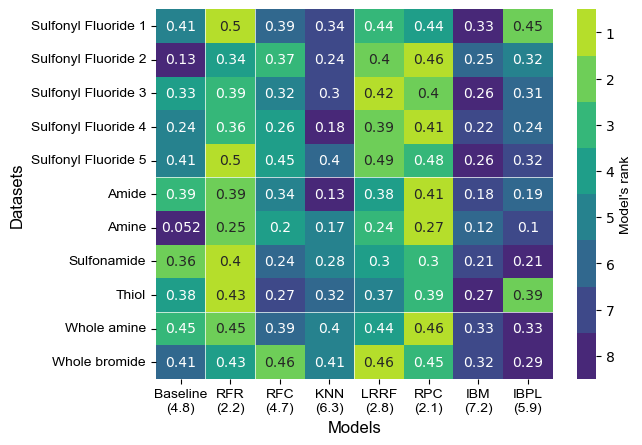

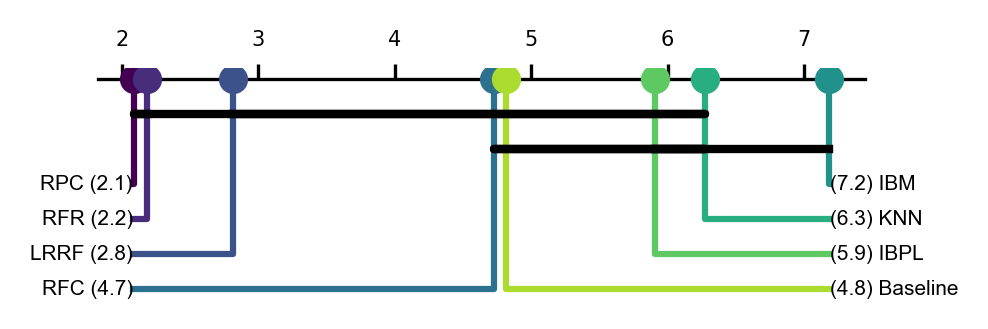

In [15]:
plot_rr_heatmap(m1_combined_kt_table, all_models_ordered, datasets)
plot_bonferroni_dunn(m1_combined_kt_table, all_models_ordered)

# Datasets randomly missing 50%

In [16]:
## For the NN_based models
m2_fp_analyzer = Analyzer("fp", all_models_ordered, 2)
m2_fp_perf_df = m2_fp_analyzer.avg_perf_df

# 
m2_desc_analyzer = Analyzer("desc", rf_based_models_ordered, 2)
m2_desc_perf_df = m2_desc_analyzer.avg_perf_df

# Then combine with the nearest-neighbor based models
m2_combined_avg_perf_df = pd.concat([
    m2_fp_perf_df[m2_fp_perf_df["model"].isin(["KNN", "IBM", "IBPL"])], 
    m2_desc_perf_df
])

m2_combined_rr_table, m2_combined_kt_table = get_rr_kt_tables(m2_combined_avg_perf_df, all_models_ordered)
m2_p_combined_rr, m2_p_combined_kt = run_friedman_tests(m2_combined_rr_table, m2_combined_kt_table, all_models_ordered)

print(m2_p_combined_rr, m2_p_combined_kt)

0.00045015843379107097 5.712570796878898e-07


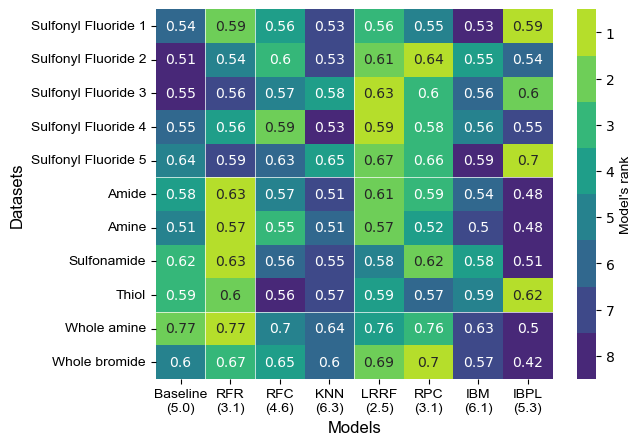

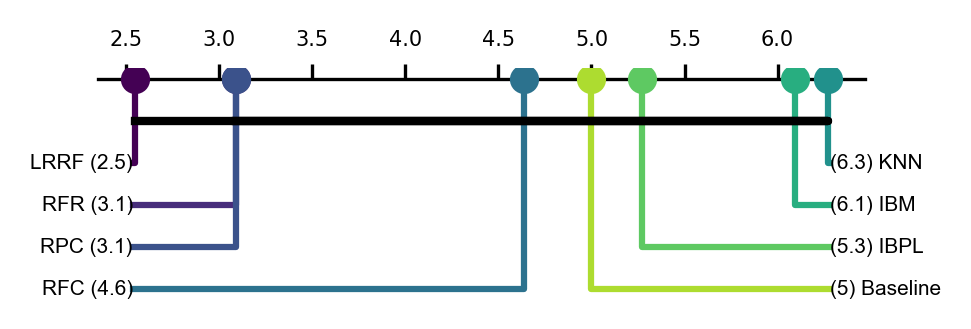

In [17]:
plot_rr_heatmap(m2_combined_rr_table, all_models_ordered, datasets)
plot_bonferroni_dunn(m2_combined_rr_table, all_models_ordered)

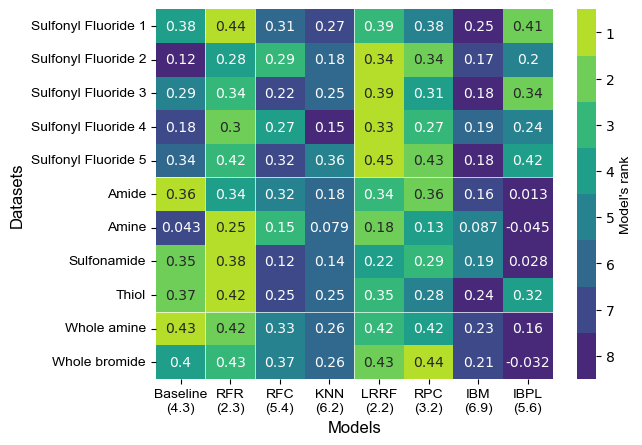

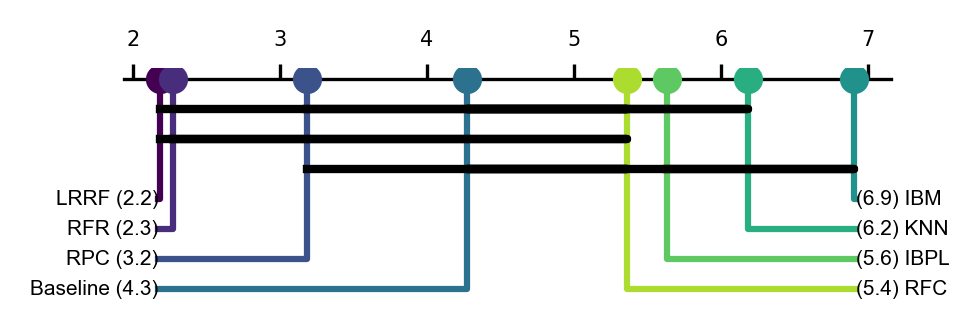

In [18]:
plot_rr_heatmap(m2_combined_kt_table, all_models_ordered, datasets)
plot_bonferroni_dunn(m2_combined_kt_table, all_models_ordered)

# All data schemes together

### Drawing a trendline trellis

Text(0.47, 0.01, 'Missing Data (%)')

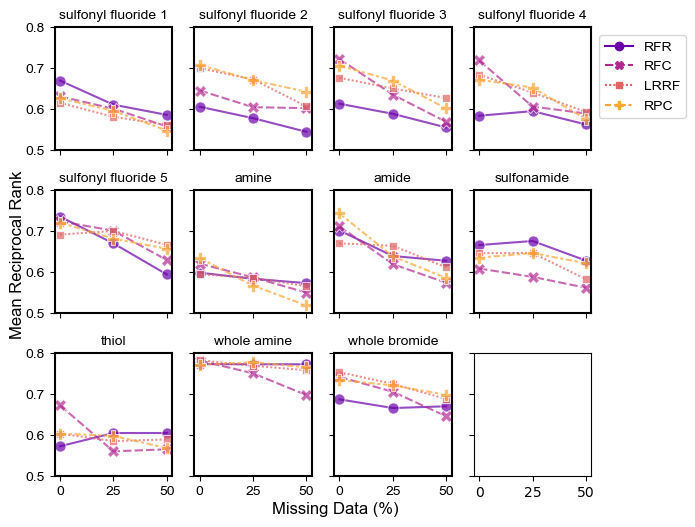

In [19]:
full_df = pd.concat([combined_avg_perf_df, m1_combined_avg_perf_df, m2_combined_avg_perf_df])
full_df["Missing Portion"] = [0]*combined_avg_perf_df.shape[0] + [25]*m1_combined_avg_perf_df.shape[0] + [50] * m2_combined_avg_perf_df.shape[0]

fig, ax = plt.subplots(ncols=4, nrows=3, sharex=True, sharey=True, tight_layout=True, figsize=(6.9,5.2))
for i, dataset_to_plot in enumerate(full_df["dataset"].unique()) :
    row = i // 4
    col = i % 4
    sns.lineplot(
        full_df[
            (full_df["model"].isin(["RFR","RFC","LRRF","RPC"])) &\
            (full_df["dataset"]==dataset_to_plot)
        ], 
        x="Missing Portion", y="average reciprocal rank",
        hue="model", style="model", ax=ax[row, col], markers=True,
        palette="plasma",
        markersize=8, alpha=0.7
    )
    ax[row, col].set_xticks([0,25,50])
    ax[row, col].set_yticks([0.5+0.1*x for x in range(4)])
    if row == 2 :
        ax[row, col].set_xticklabels([0,25,50], fontdict={"fontsize":10, "fontfamily":"arial"})
        ax[row, col].set_xlabel("")
    if col == 0 :
        ax[row, col].set_yticklabels([0.5+0.1*x for x in range(4)], fontdict={"fontsize":10, "fontfamily":"arial"})
        ax[row, col].set_ylabel("")
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[row, col].spines[axis].set_linewidth(1.5)
    if row == 0 and col == 3 :
        l = ax[row, col].legend(bbox_to_anchor=(1.01,0.99)) 
        plt.setp(l.texts, family="arial", size=10)
        pass
    else :
        ax[row, col].get_legend().remove()
    title = dataset_to_plot.split("-")[1]
    if "sulfonyl" in title :
        ind_num = int(title[-1])+1
        ax[row, col].set_title(title[:-1]+str(ind_num), fontsize=10, fontfamily="arial")
    else :
        ax[row, col].set_title(title, fontsize=10, fontfamily="arial")

fig.text(0.01, 0.5, "Mean Reciprocal Rank", ha="center", va="center", rotation="vertical", fontdict={"fontsize":12, "fontfamily":"arial"})
fig.text(0.47, 0.01, "Missing Data (%)", ha="center", va="center", fontdict={"fontsize":12, "fontfamily":"arial"})
# plt.savefig("figures/Figure5_v1.svg", dpi=300, format="svg")

### Comparing robustness against missing reactions

In [20]:
# Student t-test of decrease in performance by missing reactions 
m2_diff = m2_combined_rr_table - combined_rr_table

rf_models = ["RFR", "RFC", "LRRF", "RPC"]
m2_p_vals = np.zeros((len(rf_models), len(rf_models)))
for model1, model2 in combinations(rf_models, 2) :
    t, p = ttest_ind(m2_diff[model1].to_numpy(), m2_diff[model2].to_numpy())
    print(model1, model2, p)
# AFter the Bonferonni correction, LRRF is the only one significantly better than RFC
# in terms of degradation in performance

RFR RFC 0.010582748706852775
RFR LRRF 0.6521406861882615
RFR RPC 0.20235457455374914
RFC LRRF 0.00480931157580084
RFC RPC 0.19097695146495214
LRRF RPC 0.25840867297178766


### Comparing variation between different folds

/var/folders/05/jxqj_ld96mx38n9knzsjp58c0000gn/T/ipykernel_16075/1331724458.py:72: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(rf_models, fontdict={"fontfamily":"arial", "fontsize":10})


[Text(0, 0, 'RFR'), Text(1, 0, 'RFC'), Text(2, 0, 'LRRF'), Text(3, 0, 'RPC')]

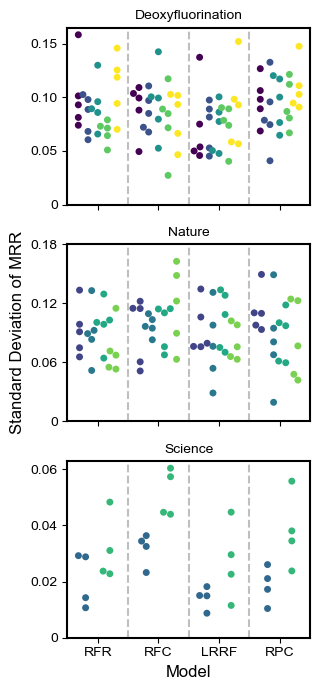

In [ ]:
fig, ax = plt.subplots(nrows=3, figsize=(3.3, 7), sharex=True, tight_layout=True)

desc_m1_deoxy_perf_df = m1_desc_analyzer.deoxy_perf_df
desc_m1_deoxy_perf_df["sulfonyl_fluoride"] = [i//1600 + 1 for i in range(desc_m1_deoxy_perf_df.shape[0])]
mean_rr_df = desc_m1_deoxy_perf_df.groupby([
    "model", "test_compound", "evaluation_loop", "sulfonyl_fluoride"
])["reciprocal_rank"].mean().reset_index() # Average across each CV test fold
m1_deoxy_var_df = mean_rr_df.groupby([
    "model", "test_compound", "sulfonyl_fluoride"
])["reciprocal_rank"].std().reset_index() # Standard deviation across each random mask
sub_m1_deoxy_df = m1_deoxy_var_df[m1_deoxy_var_df["model"].isin(rf_models)]
sns.swarmplot(
    sub_m1_deoxy_df, 
    x="model", y="reciprocal_rank", hue="sulfonyl_fluoride", dodge=True,
    palette="viridis", order=rf_models,
    ax=ax[0], legend=False
)

m1_nature_dfs = [m1_desc_analyzer.amide_perf_df, m1_desc_analyzer.amine_perf_df, m1_desc_analyzer.sulfon_perf_df, m1_desc_analyzer.thiol_perf_df]
nature_datasets = ["Amide", "Amine", "Sulfonamide", "Thiol"]

m1_nature_var_dfs = []
for m1_df, name in zip(m1_nature_dfs, nature_datasets) : 
    mean_rr_df = m1_df.groupby(["model", "test_compound", "evaluation_loop"])["reciprocal_rank"].mean().reset_index()
    var_df = mean_rr_df.groupby(["model", "test_compound"])["reciprocal_rank"].std().reset_index()
    var_df["dataset"] = [name] * var_df.shape[0]
    m1_nature_var_dfs.append(var_df)

m1_nature_var_df = pd.concat(m1_nature_var_dfs)
sns.swarmplot(
    m1_nature_var_df[m1_nature_var_df["model"].isin(rf_models)], 
    x="model", y="reciprocal_rank", hue="dataset", dodge=True,palette="viridis", order=rf_models,
    ax=ax[1], legend=False
)

science_datasets = ["whole_amine", "whole_bromide"]
m1_science_dfs = [m1_desc_analyzer.whole_amine_perf_df, m1_desc_analyzer.whole_bromide_perf_df]

m1_science_var_dfs = []
for m1_df, name in zip(m1_science_dfs, science_datasets) : 
    mean_rr_df = m1_df.groupby(["model", "test_compound", "evaluation_loop"])["reciprocal_rank"].mean().reset_index()
    var_df = mean_rr_df.groupby(["model", "test_compound"])["reciprocal_rank"].std().reset_index()
    var_df["dataset"] = [name] * var_df.shape[0]
    m1_science_var_dfs.append(var_df)

m1_science_var_df = pd.concat(m1_science_var_dfs)
sns.swarmplot(
    m1_science_var_df[m1_science_var_df["model"].isin(rf_models)], 
    x="model", y="reciprocal_rank", hue="dataset", dodge=True,palette="viridis", order=rf_models,
    ax=ax[2], legend=False
)

ax[0].set_yticks([0, 0.05, 0.10, 0.15])
ax[0].set_yticklabels([0, 0.05, "0.10", 0.15], fontdict={"fontfamily":"arial", "fontsize":10})
ax[1].set_yticks([0, 0.06, 0.12, 0.18])
ax[1].set_yticklabels([0, 0.06, 0.12, 0.18], fontdict={"fontfamily":"arial", "fontsize":10})
ax[2].set_yticks([0, 0.02, 0.04, 0.06])
ax[2].set_yticklabels([0, 0.02, 0.04, 0.06], fontdict={"fontfamily":"arial", "fontsize":10})

datasets = ["Deoxyfluorination", "Nature", "Science"]
for i in range(3):
    ax[i].set_title(datasets[i], fontdict={"fontfamily":"arial", "fontsize":10})
    if i!= 1 :
        ax[i].set_ylabel("")
    else :
        ax[i].set_ylabel("Standard Deviation of MRR", fontdict={"fontfamily":"arial", "fontsize":12})
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[i].spines[axis].set_linewidth(1.5)
    for j in range(1,4):
        ax[i].axvline(j-0.5, 0, 1, c="grey", ls="--", alpha=0.5)
ax[2].set_xlabel("Model", fontdict={"fontfamily":"arial", "fontsize":12})    
ax[2].set_xticklabels(rf_models, fontdict={"fontfamily":"arial", "fontsize":10})    

In [ ]:
desc_m2_deoxy_perf_df = m2_desc_analyzer.deoxy_perf_df
new_comp_starts_at = [0]
rfr_inds = desc_m2_deoxy_perf_df[desc_m2_deoxy_perf_df["model"]=="RFR"].index.tolist()
for i, ind in enumerate(rfr_inds) :
    if i> 0 :
        if ind - rfr_inds[i-1] > 1 :
            new_comp_starts_at.append(ind)
print("NEW COMPOUND STARTS", new_comp_starts_at)

NEW COMPOUND STARTS [0, 1600, 3200, 4800, 6400]


/var/folders/05/jxqj_ld96mx38n9knzsjp58c0000gn/T/ipykernel_16075/3415722944.py:70: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[2].set_xticklabels(rf_models, fontdict={"fontfamily":"arial", "fontsize":10})


[Text(0, 0, 'RFR'), Text(1, 0, 'RFC'), Text(2, 0, 'LRRF'), Text(3, 0, 'RPC')]

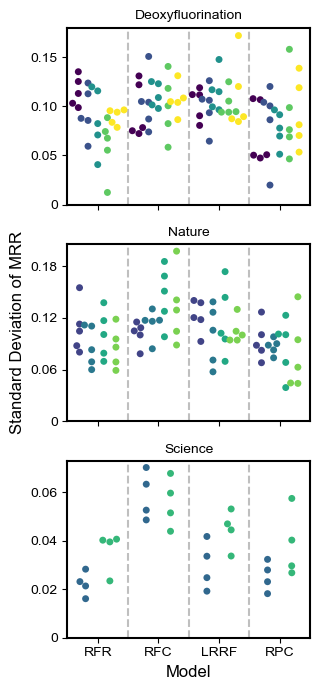

In [ ]:
fig, ax = plt.subplots(nrows=3, figsize=(3.3, 7), sharex=True, tight_layout=True)

desc_m2_deoxy_perf_df["sulfonyl_fluoride"] = [i//1600 + 1 for i in range(desc_m2_deoxy_perf_df.shape[0])]
mean_rr_df = desc_m2_deoxy_perf_df.groupby([
    "model", "test_compound", "evaluation_loop", "sulfonyl_fluoride"
])["reciprocal_rank"].mean().reset_index() # Average across each CV test fold
m2_deoxy_var_df = mean_rr_df.groupby([
    "model", "test_compound", "sulfonyl_fluoride"
])["reciprocal_rank"].std().reset_index() # Standard deviation across each random mask
sub_m2_deoxy_df = m2_deoxy_var_df[m2_deoxy_var_df["model"].isin(rf_models)]
sns.swarmplot(
    sub_m2_deoxy_df, 
    x="model", y="reciprocal_rank", hue="sulfonyl_fluoride", dodge=True,
    palette="viridis", order=rf_models,
    ax=ax[0], legend=False
)

m2_nature_dfs = [m2_desc_analyzer.amide_perf_df, m2_desc_analyzer.amine_perf_df, m2_desc_analyzer.sulfon_perf_df, m2_desc_analyzer.thiol_perf_df]
nature_datasets = ["Amide", "Amine", "Sulfonamide", "Thiol"]

m2_nature_var_dfs = []
for m2_df, name in zip(m2_nature_dfs, nature_datasets) : 
    mean_rr_df = m2_df.groupby(["model", "test_compound", "evaluation_loop"])["reciprocal_rank"].mean().reset_index()
    var_df = mean_rr_df.groupby(["model", "test_compound"])["reciprocal_rank"].std().reset_index()
    var_df["dataset"] = [name] * var_df.shape[0]
    m2_nature_var_dfs.append(var_df)

m2_nature_var_df = pd.concat(m2_nature_var_dfs)
sns.swarmplot(
    m2_nature_var_df[m2_nature_var_df["model"].isin(rf_models)], 
    x="model", y="reciprocal_rank", hue="dataset", dodge=True,palette="viridis", order=rf_models,
    ax=ax[1], legend=False
)

m2_science_dfs = [m2_desc_analyzer.whole_amine_perf_df, m2_desc_analyzer.whole_bromide_perf_df]

m2_science_var_dfs = []
for m2_df, name in zip(m2_science_dfs, science_datasets) : 
    mean_rr_df = m2_df.groupby(["model", "test_compound", "evaluation_loop"])["reciprocal_rank"].mean().reset_index()
    var_df = mean_rr_df.groupby(["model", "test_compound"])["reciprocal_rank"].std().reset_index()
    var_df["dataset"] = [name] * var_df.shape[0]
    m2_science_var_dfs.append(var_df)

m2_science_var_df = pd.concat(m2_science_var_dfs)
sns.swarmplot(
    m2_science_var_df[m2_science_var_df["model"].isin(rf_models)], 
    x="model", y="reciprocal_rank", hue="dataset", dodge=True,palette="viridis", order=rf_models,
    ax=ax[2], legend=False
)

ax[0].set_yticks([0, 0.05, 0.10, 0.15])
ax[0].set_yticklabels([0, 0.05, "0.10", 0.15], fontdict={"fontfamily":"arial", "fontsize":10})
ax[1].set_yticks([0, 0.06, 0.12, 0.18])
ax[1].set_yticklabels([0, 0.06, 0.12, 0.18], fontdict={"fontfamily":"arial", "fontsize":10})
ax[2].set_yticks([0, 0.02, 0.04, 0.06])
ax[2].set_yticklabels([0, 0.02, 0.04, 0.06], fontdict={"fontfamily":"arial", "fontsize":10})

datasets = ["Deoxyfluorination", "Nature", "Science"]
for i in range(3):
    ax[i].set_title(datasets[i], fontdict={"fontfamily":"arial", "fontsize":10})
    if i!= 1 :
        ax[i].set_ylabel("")
    else :
        ax[i].set_ylabel("Standard Deviation of MRR", fontdict={"fontfamily":"arial", "fontsize":12})
    for axis in ['top', 'bottom', 'left', 'right']:
        ax[i].spines[axis].set_linewidth(1.5)
    for j in range(1,4):
        ax[i].axvline(j-0.5, 0, 1, c="grey", ls="--", alpha=0.5)
ax[2].set_xlabel("Model", fontdict={"fontfamily":"arial", "fontsize":12})    
ax[2].set_xticklabels(rf_models, fontdict={"fontfamily":"arial", "fontsize":10})    

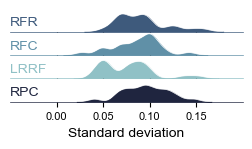

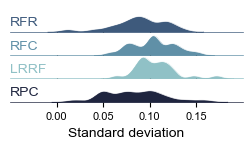

In [ ]:
std_sub_m1_deoxy = sub_m1_deoxy_df.rename(columns={"reciprocal_rank":"std"})
plot_std_kde_plot(std_sub_m1_deoxy, rf_models, save="Figure5B_deoxy1.svg")

std_sub_m2_deoxy = sub_m2_deoxy_df.rename(columns={"reciprocal_rank":"std"})
plot_std_kde_plot(std_sub_m2_deoxy, rf_models, save="Figure5B_deoxy2.svg")

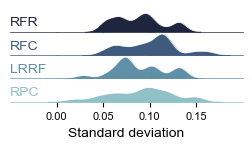

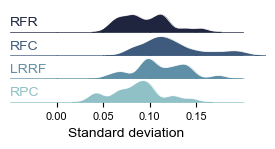

In [ ]:
std_sub_m1_nature = m1_nature_var_df.rename(columns={"reciprocal_rank":"std"})
std_sub_m2_nature = m2_nature_var_df.rename(columns={"reciprocal_rank":"std"})
plot_std_kde_plot(std_sub_m1_nature, rf_models, save="Figure5B_nature1.svg")
plot_std_kde_plot(std_sub_m2_nature, rf_models, save="Figure5B_nature2.svg")

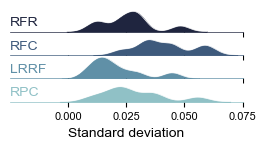

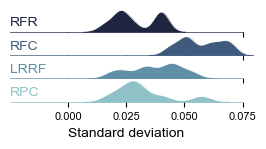

In [ ]:
std_sub_m1_science = m1_science_var_df.rename(columns={"reciprocal_rank":"std"})
std_sub_m2_science = m2_science_var_df.rename(columns={"reciprocal_rank":"std"})
plot_std_kde_plot(std_sub_m1_science, rf_models, xlim=(-0.025, 0.075), xticks=[0, 0.025, 0.050, 0.075], save="Figure5B_science1.svg")
plot_std_kde_plot(std_sub_m2_science, rf_models, xlim=(-0.025, 0.075), xticks=[0, 0.025, 0.050, 0.075], save="Figure5B_science2.svg")

# Datasets with more than 10 conditions

In [ ]:
more_datasets = ["Borylation", "Informer 1", "Informer 2", "Ullmann"]

## Complete

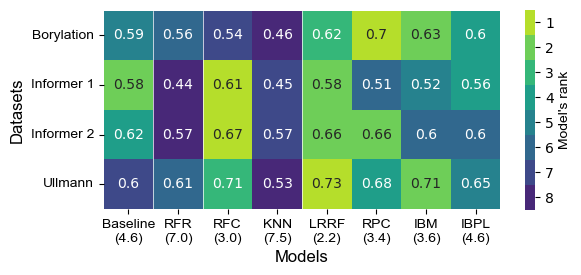

In [ ]:
fp_analyzer2 = MoreConditionAnalyzer("fp", all_models_ordered) 
fp_perf_df2 = fp_analyzer2.avg_perf_df

fp_combined_rr_table2, fp_combined_kt_table2 = get_rr_kt_tables(fp_perf_df2, all_models_ordered)
plot_rr_heatmap(fp_combined_rr_table2, all_models_ordered, more_datasets, square=True, cbar_kws={"shrink":0.54})

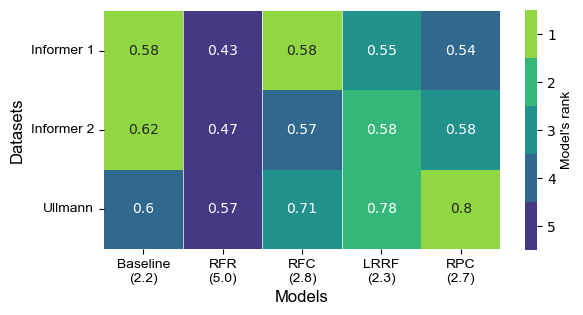

In [ ]:
desc_analyzer2 = MoreConditionAnalyzer("desc", rf_based_models_ordered) 
desc_perf_df2 = desc_analyzer2.avg_perf_df

desc_combined_rr_table2, desc_combined_kt_table2 = get_rr_kt_tables(desc_perf_df2, rf_based_models_ordered)
plot_rr_heatmap(desc_combined_rr_table2, rf_based_models_ordered, more_datasets[1:], square=True, cbar_kws={"shrink":0.65}, vline_pos=[1,2,3])

## Missing ~20% data

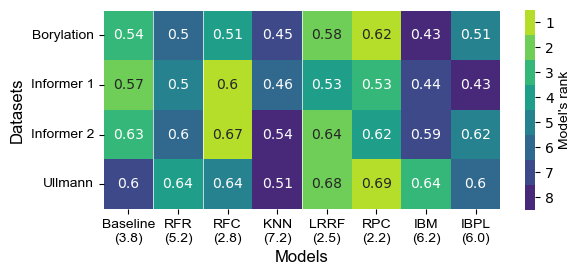

In [ ]:
m20_fp_analyzer2 = MoreConditionAnalyzer("fp", all_models_ordered, [4, 4, 3]) 
m20_fp_perf_df2 = m20_fp_analyzer2.avg_perf_df

m20_fp_combined_rr_table2, m20_fp_combined_kt_table2 = get_rr_kt_tables(m20_fp_perf_df2, all_models_ordered)
plot_rr_heatmap(m20_fp_combined_rr_table2, all_models_ordered, more_datasets, square=True, cbar_kws={"shrink":0.54})

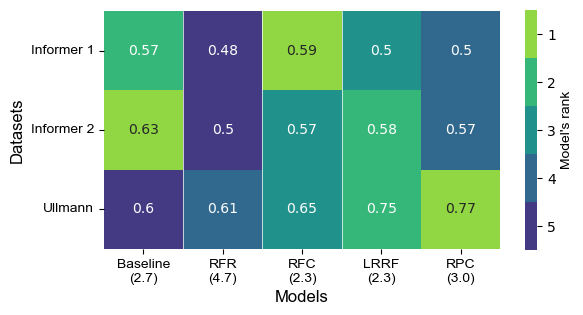

In [ ]:
m20_desc_analyzer2 = MoreConditionAnalyzer("desc", rf_based_models_ordered, [4,4,3]) 
m20_desc_perf_df2 = m20_desc_analyzer2.avg_perf_df

m20_desc_combined_rr_table2, m20_desc_combined_kt_table2 = get_rr_kt_tables(m20_desc_perf_df2, rf_based_models_ordered)
plot_rr_heatmap(m20_desc_combined_rr_table2, rf_based_models_ordered, more_datasets[1:], square=True, cbar_kws={"shrink":0.65}, vline_pos=[1,2,3])

## Missing 50% data

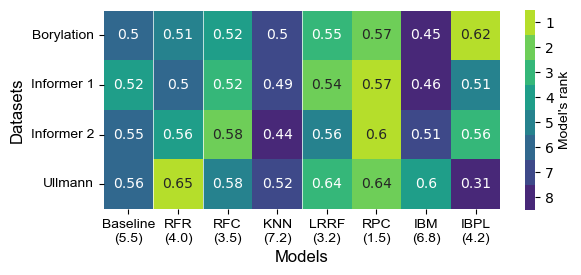

In [ ]:
m50_fp_analyzer2 = MoreConditionAnalyzer("fp", all_models_ordered, [10, 9, 6]) 
m50_fp_perf_df2 = m50_fp_analyzer2.avg_perf_df

m50_fp_combined_rr_table2, m50_fp_combined_kt_table2 = get_rr_kt_tables(m50_fp_perf_df2, all_models_ordered)
plot_rr_heatmap(m50_fp_combined_rr_table2, all_models_ordered, more_datasets, square=True, cbar_kws={"shrink":0.54})

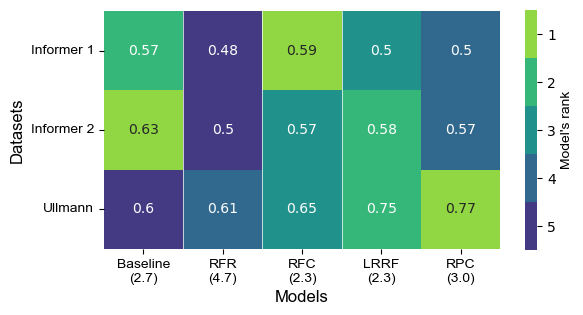

In [ ]:
m50_desc_analyzer2 = MoreConditionAnalyzer("desc", rf_based_models_ordered, [4,4,3]) 
m50_desc_perf_df2 = m50_desc_analyzer2.avg_perf_df

m50_desc_combined_rr_table2, m50_desc_combined_kt_table2 = get_rr_kt_tables(m50_desc_perf_df2, rf_based_models_ordered)
plot_rr_heatmap(m50_desc_combined_rr_table2, rf_based_models_ordered, more_datasets[1:], square=True, cbar_kws={"shrink":0.65}, vline_pos=[1,2,3])

## Deoxy dataset analysis

In [ ]:
base1_dict = prep_performance_by_model_dict("performance_excels/deoxy/fp_base_False_rem1rxns.xlsx")
base2_dict = prep_performance_by_model_dict("performance_excels/deoxy/fp_base_False_rem2rxns.xlsx")

In [ ]:
base_dicts = [{}, {}, {}, {}, {}]
for k, v in base1_dict.items():
    for i in range(5) :
        base_dicts[i].update({
            k:v.iloc[320*i:320*(i+1),:]
        })

for i in range(5):
    print(i)
    for k, v in base_dicts[i].items():
        print(k)
        # print(round(v["regret"].mean(), 1))
        print(round(v["reciprocal_rank"].mean(), 3))
    print("---------------------------")


0
RFR
0.708
Baseline
0.604
RPC
0.74
LRRF
0.706
RFC
0.695
LR
0.69
KNN
0.715
---------------------------
1
RFR
0.619
Baseline
0.514
RPC
0.663
LRRF
0.717
RFC
0.675
LR
0.619
KNN
0.632
---------------------------
2
RFR
0.664
Baseline
0.572
RPC
0.659
LRRF
0.619
RFC
0.649
LR
0.628
KNN
0.689
---------------------------
3
RFR
0.676
Baseline
0.569
RPC
0.711
LRRF
0.627
RFC
0.648
LR
0.703
KNN
0.661
---------------------------
4
RFR
0.625
Baseline
0.626
RPC
0.622
LRRF
0.723
RFC
0.731
LR
0.722
KNN
0.684
---------------------------


In [ ]:
base_dicts = [{}, {}, {}, {}, {}]
for k, v in base2_dict.items():
    for i in range(5) :
        base_dicts[i].update({
            k:v.iloc[320*i:320*(i+1),:]
        })

for i in range(5):
    print(i)
    for k, v in base_dicts[i].items():
        print(k)
        # print(round(v["regret"].mean(), 1))
        print(round(v["reciprocal_rank"].mean(), 3))
    print("---------------------------")


0
RFR
0.678
Baseline
0.598
RPC
0.727
LRRF
0.7
RFC
0.699
LR
0.673
KNN
0.7
---------------------------
1
RFR
0.583
Baseline
0.519
RPC
0.682
LRRF
0.656
RFC
0.654
LR
0.605
KNN
0.625
---------------------------
2
RFR
0.631
Baseline
0.583
RPC
0.662
LRRF
0.64
RFC
0.625
LR
0.594
KNN
0.628
---------------------------
3
RFR
0.63
Baseline
0.575
RPC
0.671
LRRF
0.631
RFC
0.663
LR
0.651
KNN
0.651
---------------------------
4
RFR
0.625
Baseline
0.61
RPC
0.631
LRRF
0.68
RFC
0.64
LR
0.647
KNN
0.662
---------------------------


## Informer dataset analysis

In [ ]:
amine2_dict = prep_performance_by_model_dict("performance_excels/informer/fp_amine_ratio_False_rem2rxns.xlsx")
amine4_dict = prep_performance_by_model_dict("performance_excels/informer/fp_amine_ratio_False_rem4rxns.xlsx")
amine6_dict = prep_performance_by_model_dict("performance_excels/informer/fp_amine_ratio_False_rem6rxns.xlsx")

cat4_dict = prep_performance_by_model_dict("performance_excels/informer/fp_catalyst_ratio_False_rem4rxns.xlsx")
cat8_dict = prep_performance_by_model_dict("performance_excels/informer/fp_catalyst_ratio_False_rem8rxns.xlsx")
cat12_dict = prep_performance_by_model_dict("performance_excels/informer/fp_catalyst_ratio_False_rem12rxns.xlsx")

In [ ]:
cat_dicts = [{}, {}, {}, {}]
for k, v in amine6_dict.items():
    for i in range(4) :
        cat_dicts[i].update({
            k:v.iloc[110*i:110*(i+1),:]
        })

for i in range(4):
    print(i)
    for k, v in cat_dicts[i].items():
        print(k)
        print(round(v["regret"].mean(), 3))
        print(round(v["reciprocal_rank"].mean(), 3))
        print(round(v["kendall_tau"].mean(), 3))
        print(round(v["mean_reciprocal_rank"].mean(), 3))
    print("---------------------------")


0
RFR
6.045
0.687
0.326
0.448
Baseline
6.673
0.64
0.198
0.195
RPC
8.273
0.586
0.149
0.356
LRRF
6.355
0.643
0.156
0.392
RFC
8.482
0.582
0.18
0.358
LR
16.909
0.401
-0.047
0.243
KNN
6.127
0.671
0.108
0.409
---------------------------
1
RFR
5.036
0.706
0.402
0.463
Baseline
5.982
0.69
0.343
0.195
RPC
5.6
0.683
0.314
0.433
LRRF
6.464
0.68
0.293
0.439
RFC
6.591
0.613
0.299
0.382
LR
23.973
0.322
-0.08
0.208
KNN
5.909
0.683
0.15
0.435
---------------------------
2
RFR
5.609
0.744
0.273
0.487
Baseline
8.627
0.666
0.173
0.236
RPC
8.482
0.639
0.122
0.416
LRRF
8.173
0.669
0.159
0.437
RFC
9.273
0.597
0.167
0.389
LR
20.5
0.424
0.027
0.28
KNN
9.109
0.636
0.19
0.428
---------------------------
3
RFR
7.127
0.676
0.343
0.452
Baseline
6.791
0.673
0.313
0.245
RPC
9.591
0.59
0.322
0.4
LRRF
9.791
0.599
0.355
0.412
RFC
12.536
0.507
0.267
0.342
LR
27.864
0.318
-0.048
0.219
KNN
10.291
0.555
0.305
0.381
---------------------------


In [ ]:
cat_dicts = [{}, {}]
for k, v in cat8_dict.items():
    for i in range(2) :
        cat_dicts[i].update({
            k:v.iloc[110*i:110*(i+1),:]
        })

for i in range(2):
    print(i)
    for k, v in cat_dicts[i].items():
        print(k)
        print(round(v["regret"].mean(), 3))
        print(round(v["reciprocal_rank"].mean(), 3))
        print(round(v["kendall_tau"].mean(), 3))
        print(round(v["mean_reciprocal_rank"].mean(), 3))
    print("---------------------------")


0
RFR
7.782
0.516
0.19
0.237
Baseline
7.0
0.531
0.223
0.068
RPC
8.018
0.499
0.226
0.233
LRRF
7.991
0.485
0.246
0.229
RFC
7.545
0.549
0.202
0.239
LR
17.882
0.293
0.012
0.141
KNN
10.009
0.458
0.113
0.209
---------------------------
1
RFR
5.982
0.749
0.276
0.296
Baseline
8.445
0.665
0.271
0.12
RPC
5.945
0.771
0.294
0.296
LRRF
5.8
0.765
0.304
0.299
RFC
6.473
0.756
0.243
0.288
LR
16.782
0.431
0.052
0.153
KNN
7.691
0.59
0.223
0.236
---------------------------


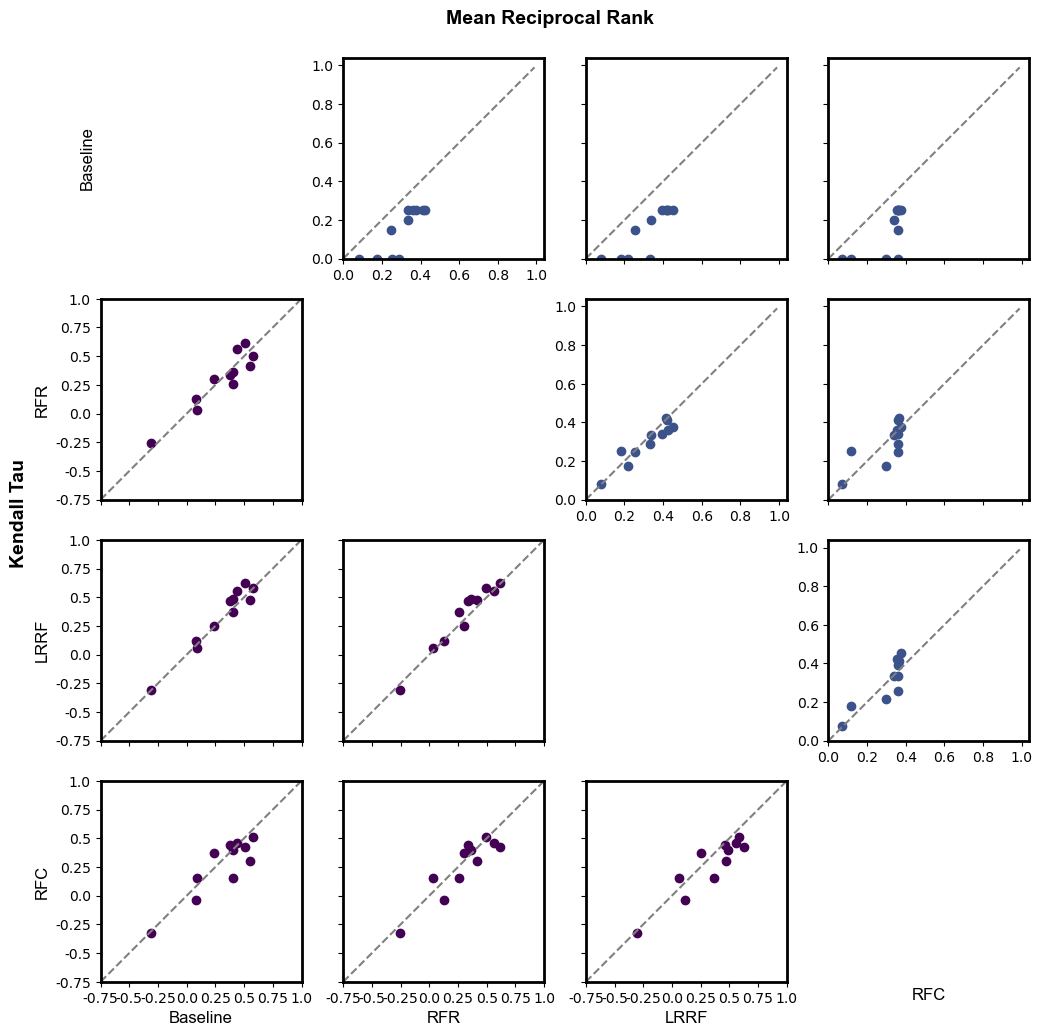

In [ ]:
trellis_of_algs(
        cat_dicts[1],
        ["Baseline", "RFR", "LRRF", "RFC"],
        "kendall_tau",
        "mean_reciprocal_rank",
        filename=None
    )

In [ ]:
amine2_dicts = [{}, {}, {}, {}]
for k, v in amine6_dict.items():
    for i in range(4) :
        amine2_dicts[i].update({
            k:v.iloc[110*i:110*(i+1),:]
        })

for i in range(4):
    print(i)
    for k, v in amine2_dicts[i].items():
        print(k)
        print(round(v["kendall_tau"].mean(), 3))
        print(round(v["mean_reciprocal_rank"].mean(), 3))
    print("---------------------------")


0
RFR
0.326
0.448
Baseline
0.198
0.195
RPC
0.149
0.356
LRRF
0.156
0.392
RFC
0.18
0.358
LR
-0.047
0.243
KNN
0.108
0.409
---------------------------
1
RFR
0.402
0.463
Baseline
0.343
0.195
RPC
0.314
0.433
LRRF
0.293
0.439
RFC
0.299
0.382
LR
-0.08
0.208
KNN
0.15
0.435
---------------------------
2
RFR
0.273
0.487
Baseline
0.173
0.236
RPC
0.122
0.416
LRRF
0.159
0.437
RFC
0.167
0.389
LR
0.027
0.28
KNN
0.19
0.428
---------------------------
3
RFR
0.343
0.452
Baseline
0.313
0.245
RPC
0.322
0.4
LRRF
0.355
0.412
RFC
0.267
0.342
LR
-0.048
0.219
KNN
0.305
0.381
---------------------------


RFR
7.0
0.676

Baseline
5.0
0.735

RPC
10.4
0.537

LRRF
3.9
0.802

RFC
3.0
0.808

LR
19.2
0.357

KNN
3.4
0.816



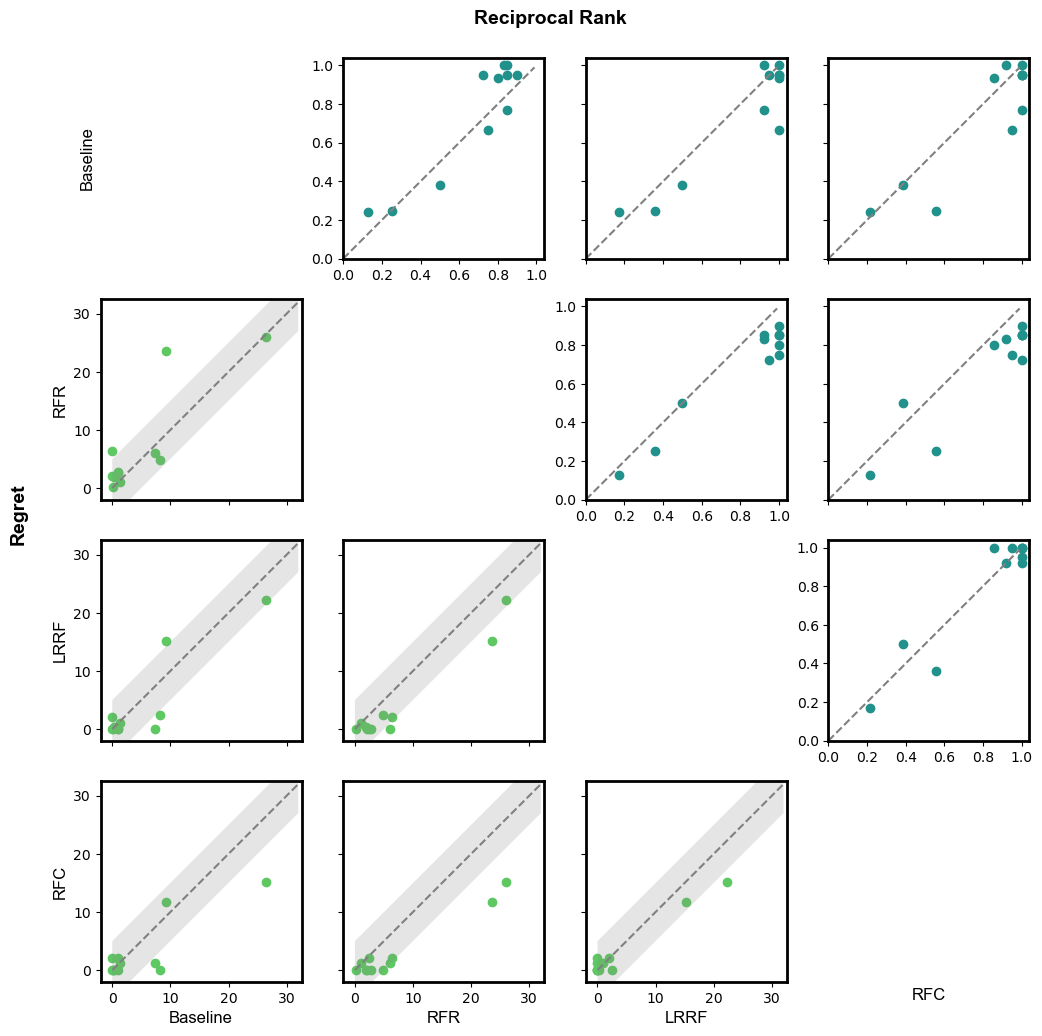

In [ ]:
trellis_of_algs(
        amine2_dicts[0],
        ["Baseline", "RFR", "LRRF", "RFC"],
        "regret",
        "reciprocal_rank",
        filename=None
    )

### Looking at stability of models

/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **

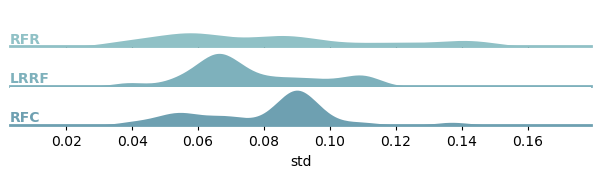

/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **

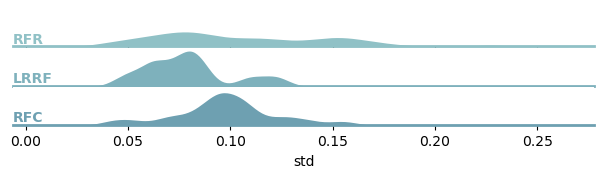

/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/opt/miniconda3/envs/label/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **

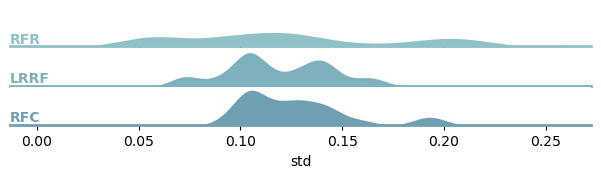

In [ ]:
# amine2_dicts = [{}, {}, {}, {}]
# for k, v in amine6_dict.items():
#     for i in range(4) :
#         amine2_dicts[i].update({
#             k:v.iloc[110*i:110*(i+1),:]
#         })
# amine2_dfs = []
# std_by_model = {"model":[], "std":[]}
# for dict_obj in amine2_dicts :
#     for k, v in dict_obj.items():
#         if k in ["RFR", "LRRF", "RFC"] :
#             std_list = []
#             for i in range(11) :
#                 std_list.append(v.iloc[10*i:10*(i+1), -4].std())
#             std_by_model["std"].extend(std_list)
#             std_by_model["model"].extend([k]*len(std_list))
for a in [cat4_dict, cat8_dict, cat12_dict]:
    cat_dicts = [{}, {}]
    for k, v in a.items():
        for i in range(2) :
            cat_dicts[i].update({
                k:v.iloc[110*i:110*(i+1),:]
            })
    cat_dfs = []
    std_by_model = {"model":[], "std":[]}
    for dict_obj in cat_dicts :
        for k, v in dict_obj.items():
            if k in ["RFR", "LRRF", "RFC"] :
                std_list = []
                for i in range(11) :
                    std_list.append(v.iloc[10*i:10*(i+1), -6].std()) # -6 : kendall tau, -4: MRR
                std_by_model["std"].extend(std_list)
                std_by_model["model"].extend([k]*len(std_list))
    df = pd.DataFrame(std_by_model)
    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
    g = sns.FacetGrid(df, row="model", hue="model", aspect=15, height=.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "std",
        bw_adjust=.5, clip_on=False,
        fill=True, alpha=1, linewidth=0.5)
    g.map(sns.kdeplot, "std", clip_on=False, color="w", lw=2, bw_adjust=.5)

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)


    g.map(label, "std")

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=.05)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)
    plt.show()

## NatureHTE dataset analysis

In [ ]:
sulfon_dict1 = prep_performance_by_model_dict("performance_excels/natureHTE/fp_sulfonamide_None_rem1rxns.xlsx")
sulfon_dict2 = prep_performance_by_model_dict("performance_excels/natureHTE/fp_sulfonamide_None_rem2rxns.xlsx")
amide_dict1 = prep_performance_by_model_dict("performance_excels/natureHTE/fp_amide_None_rem1rxns.xlsx")
amide_dict2 = prep_performance_by_model_dict("performance_excels/natureHTE/fp_amide_None_rem2rxns.xlsx")
amine_dict1 = prep_performance_by_model_dict("performance_excels/natureHTE/fp_amine_None_rem1rxns.xlsx")
amine_dict2 = prep_performance_by_model_dict("performance_excels/natureHTE/fp_amine_None_rem2rxns.xlsx")

In [ ]:
for k, v in sulfon_dict2.items():
    print(k)
    # print(round(v["regret"].mean(), 1))
    print(round(v["reciprocal_rank"].mean(), 3))
    print()

RFR
0.632

Baseline
0.642

RPC
0.614

LRRF
0.646

RFC
0.617

LR
0.548

KNN
0.575



In [ ]:
for k, v in amide_dict2.items():
    print(k)
    print(round(v["regret"].mean(), 1))
    print(round(v["reciprocal_rank"].mean(), 3))
    print()

RFR
14.3
0.618

Baseline
14.7
0.513

RPC
15.0
0.578

LRRF
12.6
0.584

RFC
13.4
0.595

LR
13.4
0.575

KNN
12.0
0.617



In [ ]:
for k, v in amine_dict2.items():
    print(k)
    # print(round(v["regret"].mean(), 1))
    print(round(v["reciprocal_rank"].mean(), 3))
    print()

RFR
0.625

Baseline
0.601

RPC
0.605

LRRF
0.584

RFC
0.576

LR
0.568

KNN
0.595



RFR
13.9
0.646

Baseline
13.1
0.606

RPC
22.3
0.627

LRRF
18.9
0.622

RFC
18.0
0.633

LR
20.4
0.619

KNN
21.1
0.624



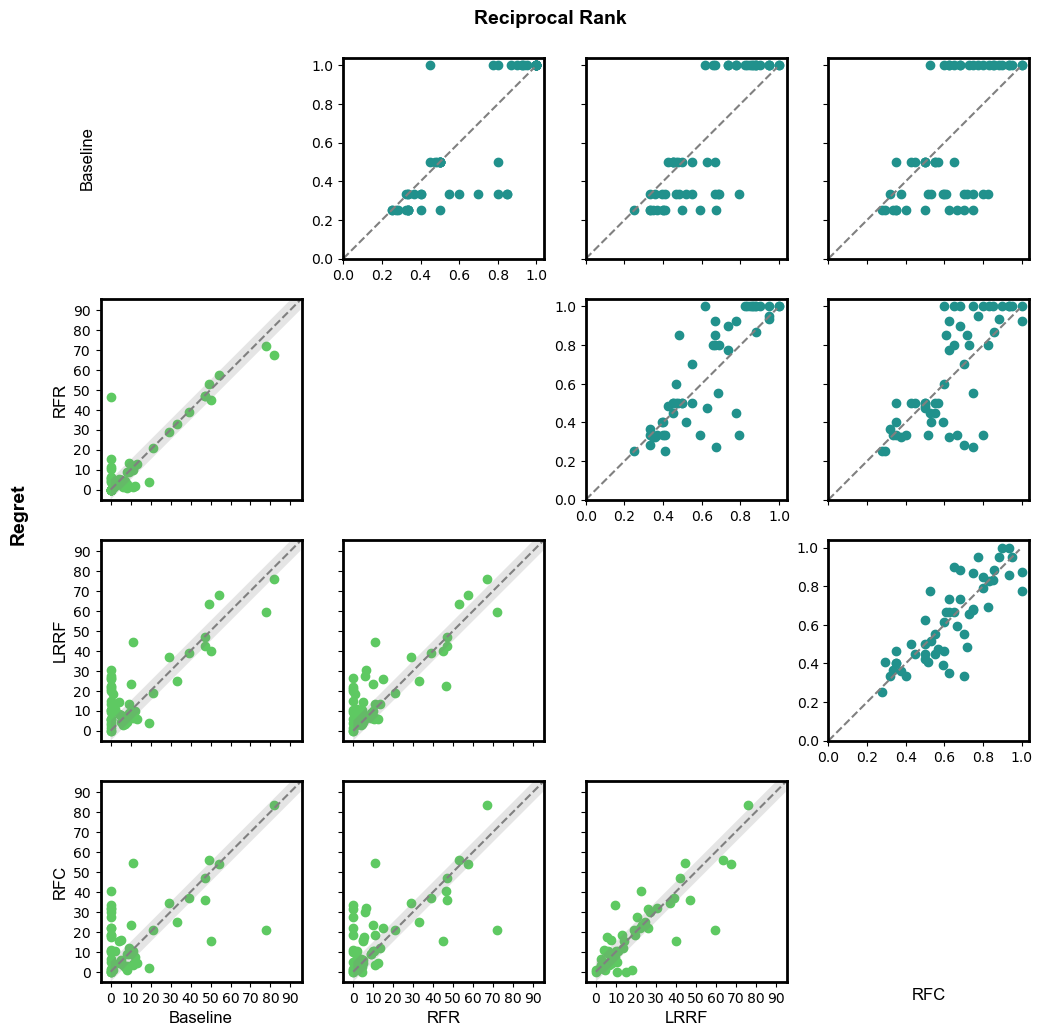

In [ ]:
for k, v in amine_dict1.items():
    print(k)
    print(round(v["regret"].mean(), 1))
    print(round(v["reciprocal_rank"].mean(), 3))
    print()

trellis_of_algs(
        amine_dict1,
        ["Baseline", "RFR", "LRRF", "RFC"],
        "regret",
        "reciprocal_rank",
        filename=None
    )

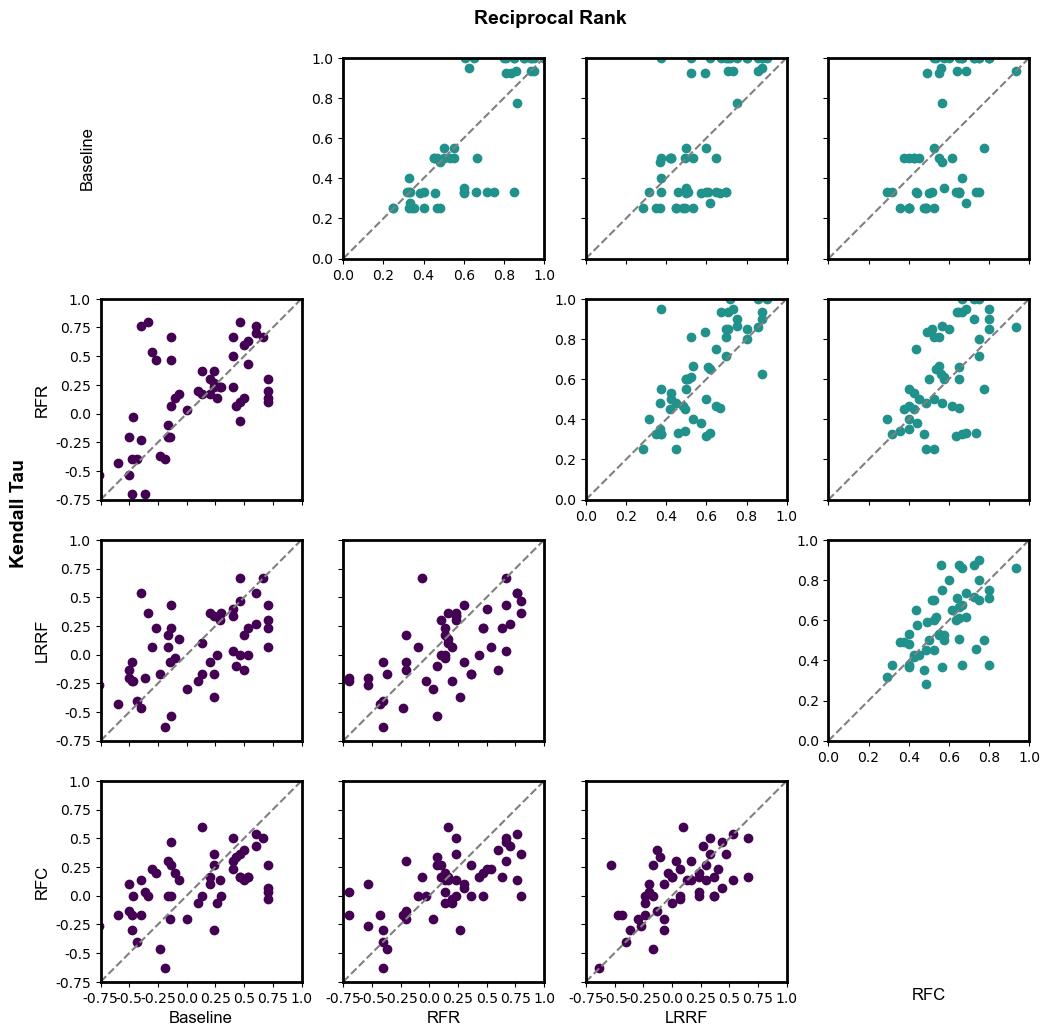

In [ ]:
trellis_of_algs(
        amine_dict,
        ["Baseline", "RFR", "LRRF", "RFC"],
        "kendall_tau",
        "reciprocal_rank",
        filename=None
    )